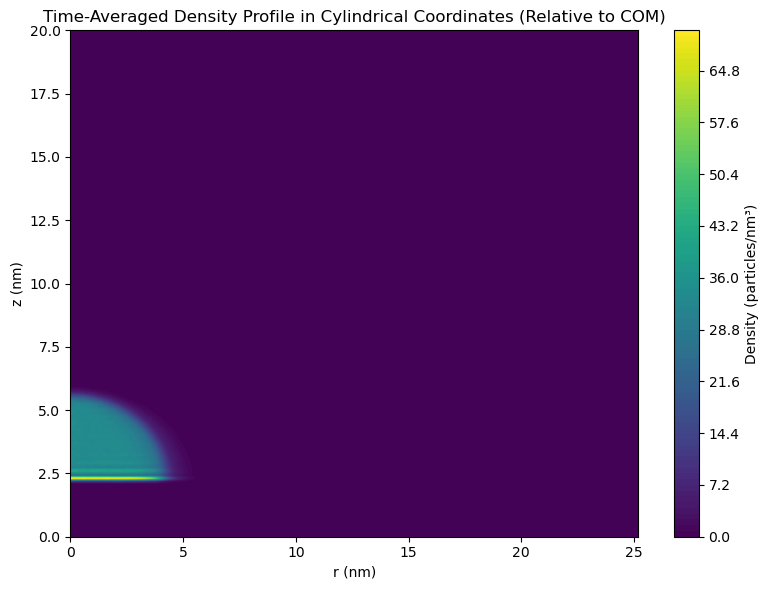

In [256]:
import numpy as np
import matplotlib.pyplot as plt

cell = [17.892, 17.7085, 20]


def parse_gro_multiframe(filepath):
    """
    Parses a multi-frame GROMACS .gro file and extracts particle coordinates for each frame.

    Args:
        filepath (str): Path to the .gro file.

    Returns:
        list: A list of frames, where each frame is a list of particle coordinates (dictionaries with x, y, z).
    """
    frames = []  # List to store all frames
    with open(filepath, 'r') as file:
        lines = file.readlines()
        i = 0
        while i < len(lines):
            if "Generated by" in lines[i]:  # Check for the frame header
                frame = []  # Store particles for this frame
                i += 1  # Move to the number of particles line
                num_particles = int(lines[i].strip())
                i += 1  # Move to the first particle line

                # Extract particle data
                for _ in range(num_particles):
                    line = lines[i]
                    x = float(line[20:28].strip())  # x-coordinate in nm
                    y = float(line[28:36].strip())  # y-coordinate in nm
                    z = float(line[36:44].strip())  # z-coordinate in nm
                    frame.append({'x': x, 'y': y, 'z': z})
                    i += 1

                frames.append(frame)  # Add this frame to the list
                i += 1  # Skip the box dimensions line
            else:
                i += 1  # Move to the next line if not a header
    return frames

# Filepath to the .gro file
gro_file = 'checking.gro'

# Read all frames from .gro file
frames = parse_gro_multiframe(gro_file)

# Center of mass (in nm)
com_x = 83.17772473040183 / 10    # Convert Å to nm
com_y = 82.02775182372607 / 10   # Convert Å to nm
com_z = 34.832820269081926 / 10   # Convert Å to nm
# com_z -= graphene_z
# Simulation parameters for cylindrical binning
delta_r = 0.1  # Radial bin size (nm)
delta_z = 0.1  # Axial bin size (nm)
r_max = np.sqrt(cell[0]**2 + cell[1]**2)  # Maximum radius (nm)
z_min = 0    # Start from 0 nm (relative to graphene plane or reference)
z_max = cell[2]   # Extend to 10 nm

# Initialize bins
# num_r_bins = int(r_max / delta_r)
num_z_bins = int((z_max - z_min) / delta_z)
num_r_bins = num_z_bins
density_bins = np.zeros((num_r_bins, num_z_bins))  # For accumulating densities

# Loop over all frames
for frame in frames:
    frame_bins = np.zeros((num_r_bins, num_z_bins))  # Temp bins for this frame
    for particle in frame:
        # Shift particle coordinates relative to COM
        x_shifted = particle['x'] - com_x
        y_shifted = particle['y'] - com_y
        z_shifted = particle['z'] #- com_z

        # Convert to cylindrical coordinates
        r = np.sqrt(x_shifted**2 + y_shifted**2)
        z = z_shifted #+ 2.014

        # Find the bin indices
        r_bin = int(r / delta_r)
        z_bin = int((z - z_min) / delta_z)

        # Update the count in the corresponding bin
        if 0 <= r_bin < num_r_bins and 0 <= z_bin < num_z_bins:
            frame_bins[r_bin, z_bin] += 1

    # Add this frame's contribution to the total density
    density_bins += frame_bins

# Average over all time frames
total_frames = len(frames)
density_bins /= total_frames

# Convert counts to densities
for r_bin in range(num_r_bins):
    for z_bin in range(num_z_bins):
        r_center = (r_bin + 0.5) * delta_r
        volume = 2 * np.pi * r_center * delta_r * delta_z
        density_bins[r_bin, z_bin] /= volume

# Prepare data for visualization
r_values = np.linspace(0, r_max, num_r_bins)
z_values = np.linspace(z_min, z_max, num_z_bins)

# Plot the density profile
plt.figure(figsize=(8, 6))
plt.contourf(r_values, z_values, density_bins.T, levels=100, cmap='viridis')  # Transpose to align axes
plt.colorbar(label='Density (particles/nm³)')
plt.xlabel('r (nm)')  # r on X-axis
plt.ylabel('z (nm)')  # z on Y-axis
plt.title('Time-Averaged Density Profile in Cylindrical Coordinates (Relative to COM)')
plt.show()


In [257]:
### Determine the center point of droplet with densest mass density ####
maxdens_idx = np.argmax(density_bins.T, axis=None) # returns the index of the maximum value in the array
maxdens_idx = np.unravel_index(maxdens_idx, density_bins.T.shape)
print(maxdens_idx)
center_line = density_bins.T[:, maxdens_idx[1]] # center line on the density

(23, 0)


[16.5868452   6.99486197  0.240533  ]
[0.12835739 0.01274999 0.02233093]


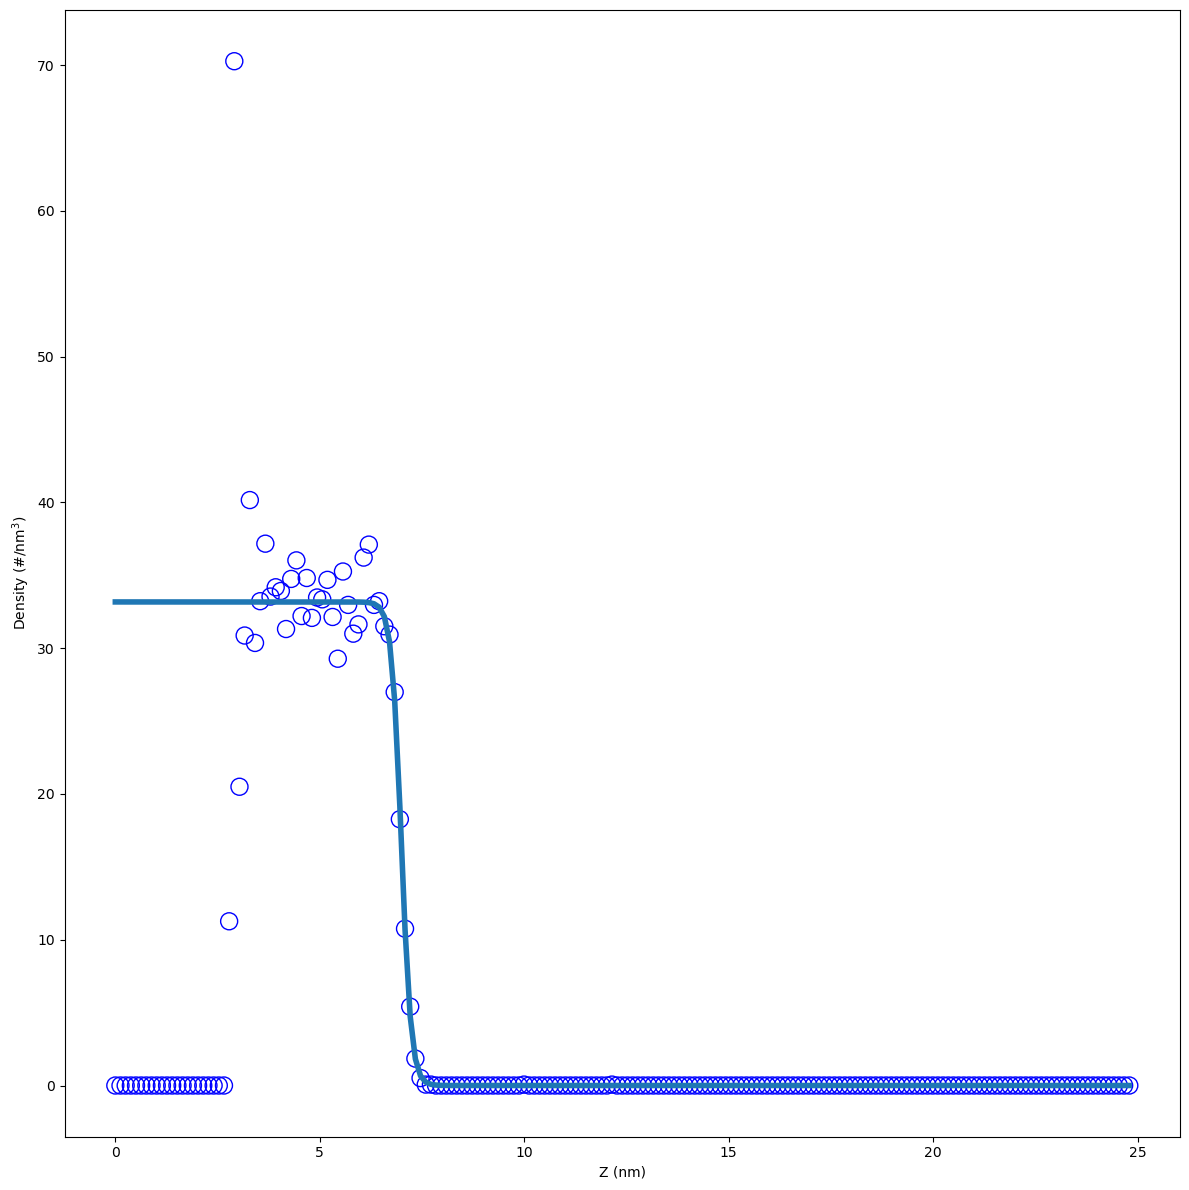

In [258]:
def density_func(x, a, b, c):
    return a * (1 - np.tanh((x - b) / c))

from scipy import optimize
density_line = np.transpose(center_line).flatten()

#### lower and upper bounds of the mass density of the droplet along the totally symmetric axis ####
zfit_index1 = np.where(np.isclose(r_values, 3.03602284))
zfit_index2 = np.where(np.isclose(r_values, 24.92068746))

#### Fitting process ######
params, params_covariance = optimize.curve_fit(
    f=density_func,
    xdata=r_values[zfit_index1[0][0] : zfit_index2[0][0]],
    ydata=density_line[zfit_index1[0][0] : zfit_index2[0][0]],
    p0=[613, 5, 2],
)

yfitteddata = density_func(r_values, params[0], params[1], params[2])

plt.figure(1, figsize=(12, 12))
fitted_curve = plt.plot(
    r_values[0 : zfit_index2[0][0]], yfitteddata[0 : zfit_index2[0][0]], linewidth=4
)
center_line_plot = plt.scatter(
    r_values[0 : zfit_index2[0][0]],
    center_line[0 : zfit_index2[0][0]],
    marker="o",
    s=150,
    facecolors="none",
    edgecolors="b",
)

# plt.ylim([0,2000])
plt.ylabel('Density (#/$\mathregular{nm^{3}}$)')
plt.xlabel('Z (nm)')

print(params)
print(np.sqrt(np.diag(params_covariance)))


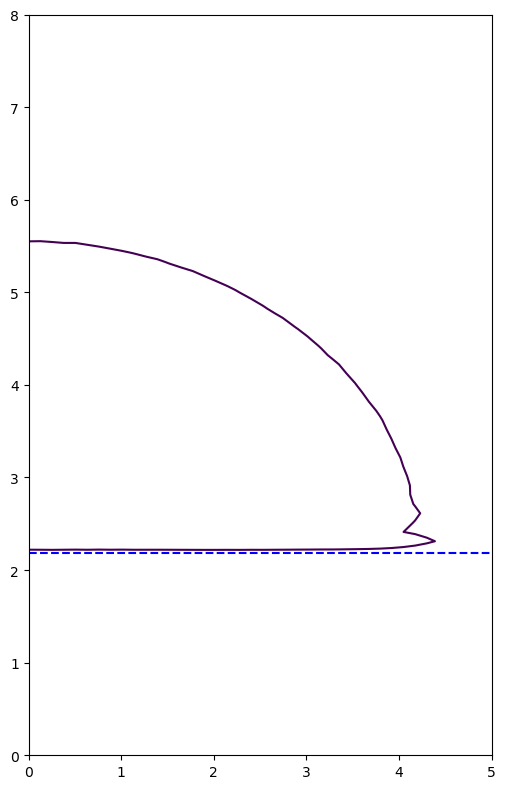

In [259]:
plt.figure(2, figsize=(8, 8))
axes = plt.gca()
axes.set_xlim([0, 5])
axes.set_ylim([0, 8])
axes.set_aspect(1)
masscontour = plt.contour(r_values, z_values, density_bins.T, levels=[params[0]])
xr = np.linspace(0,np.max(r_values),100)
y_gr = []
for i in range(len(xr)):
    y_gr.append(2.184)

plt.plot(xr,y_gr,'b--')

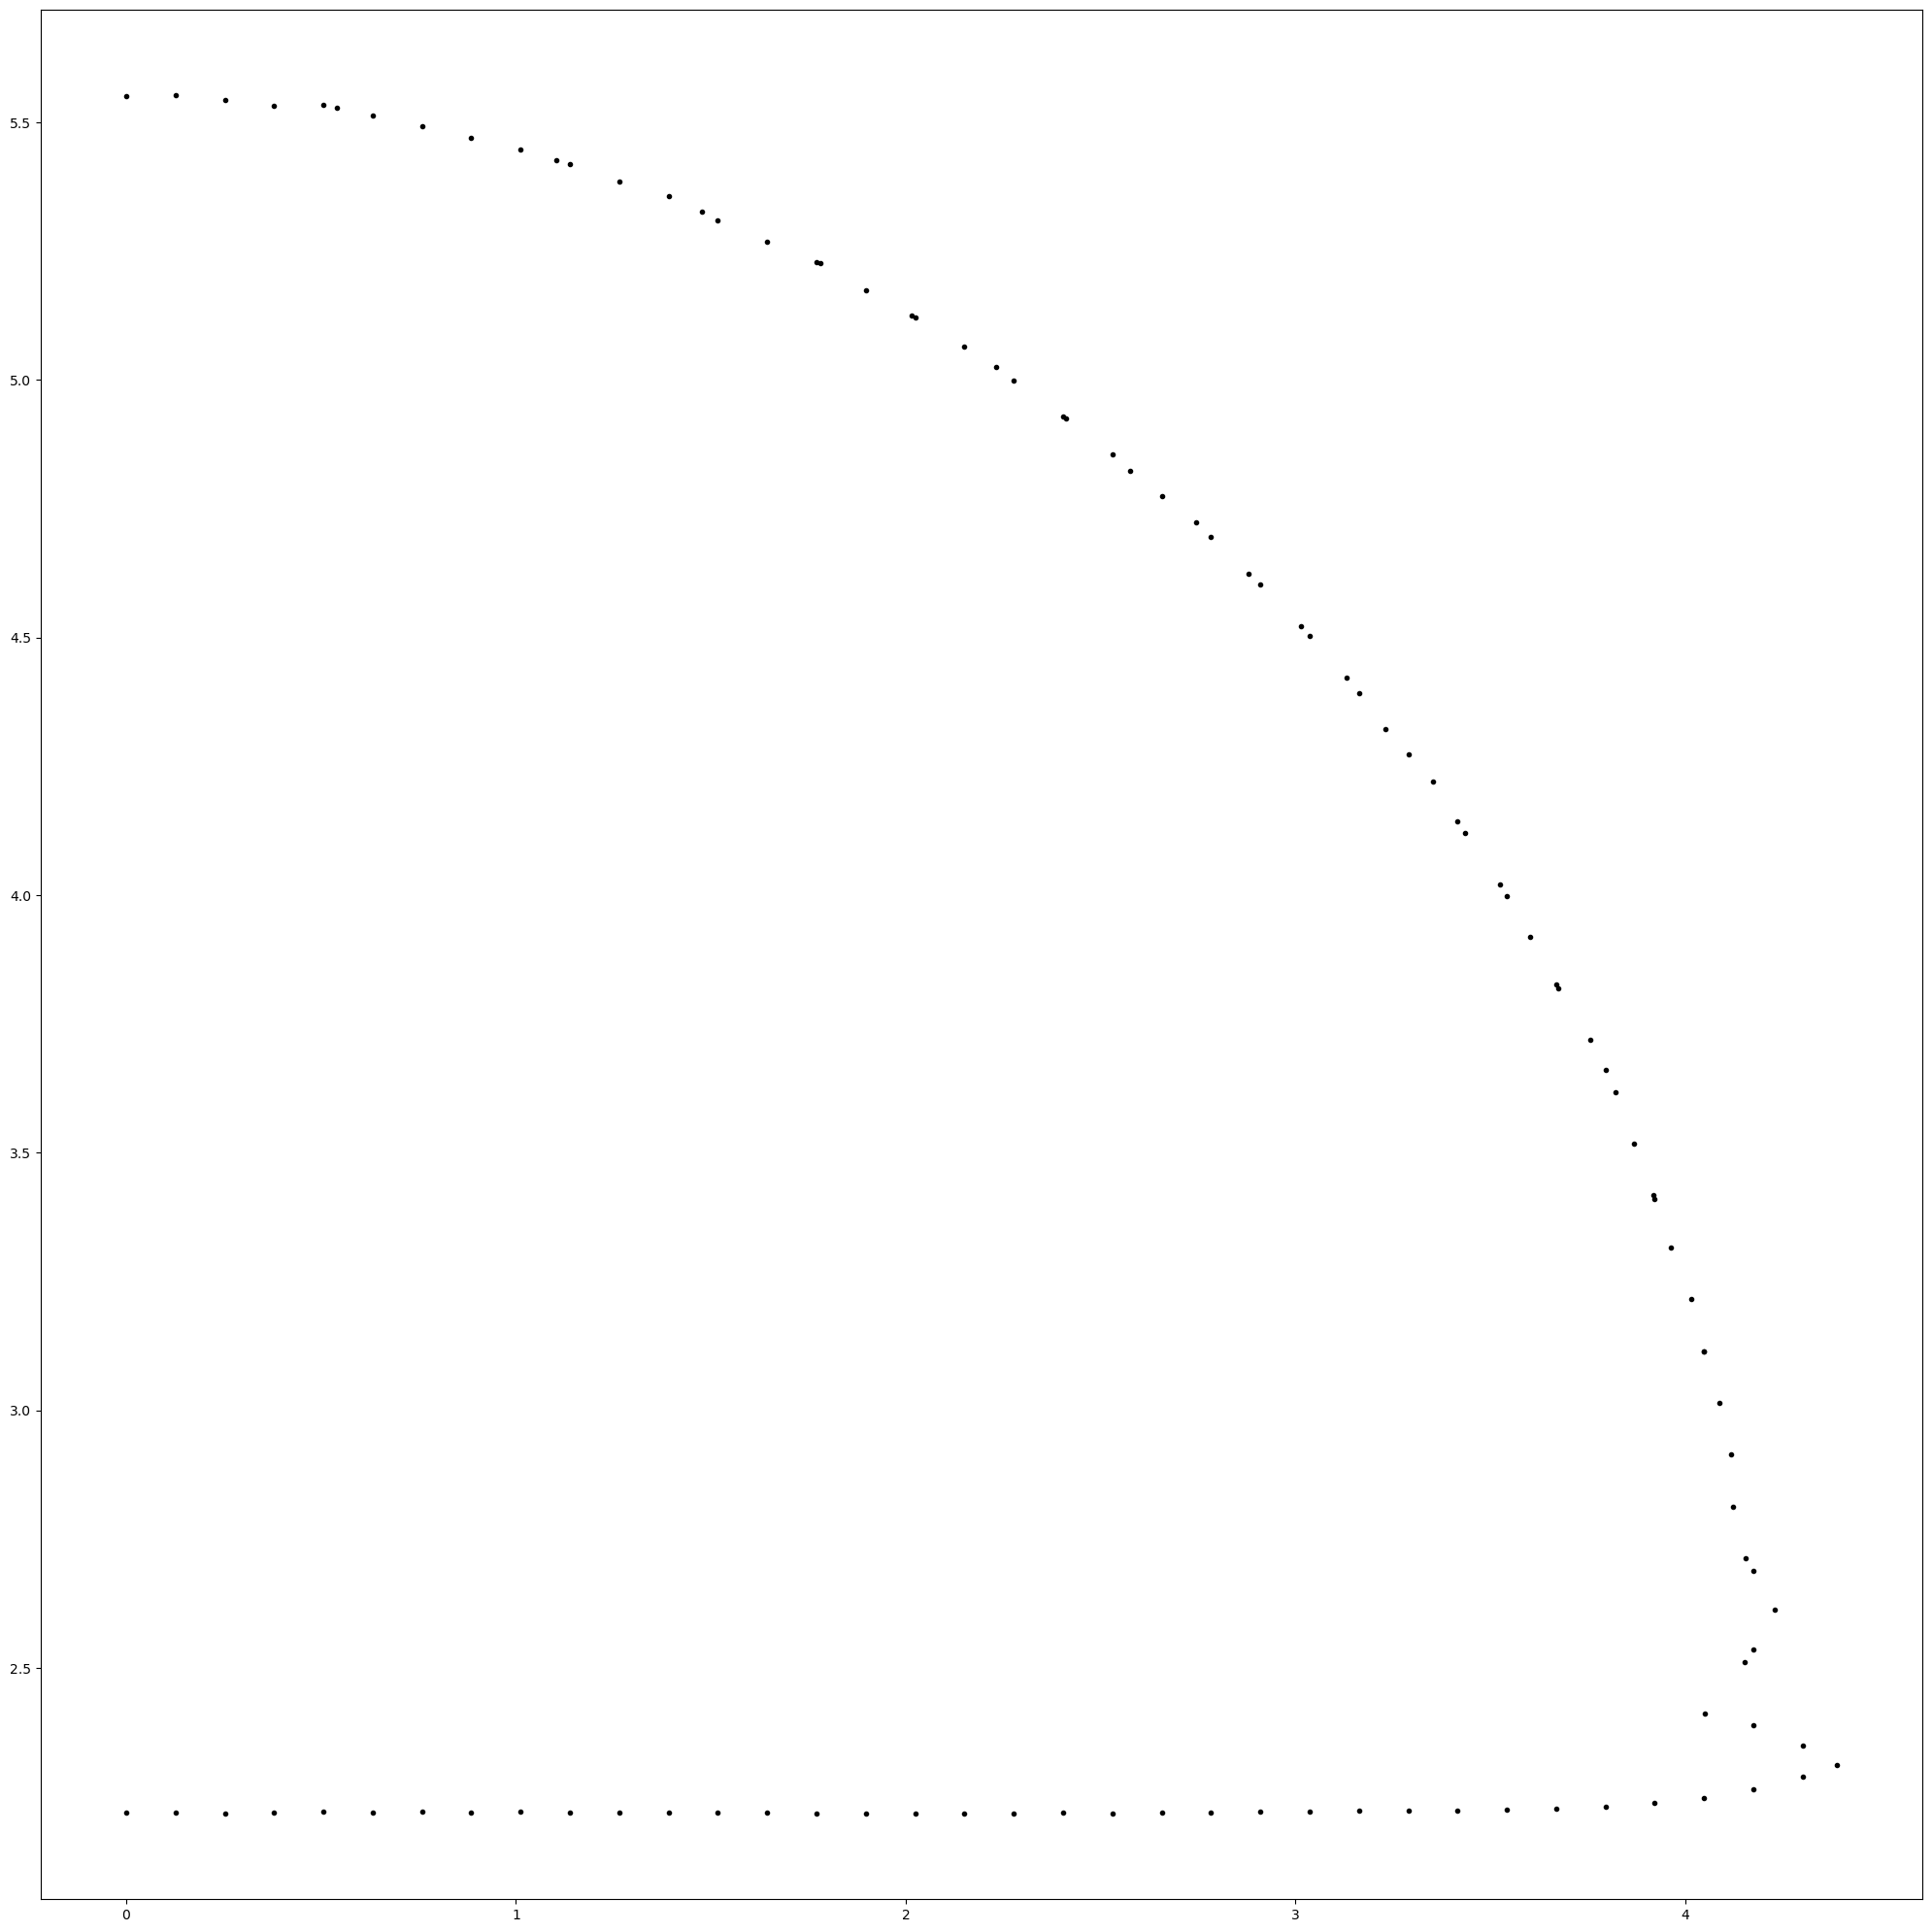

In [260]:
alpha = 0
data = masscontour.allsegs[0][alpha]
for i in range(len(data)):
    plt.plot(data[i][0],data[i][1],'k.')
    # print(data[i][1])
cell = [17.892,17.892,20] # box size
Z0 = 2.184 
import math as m

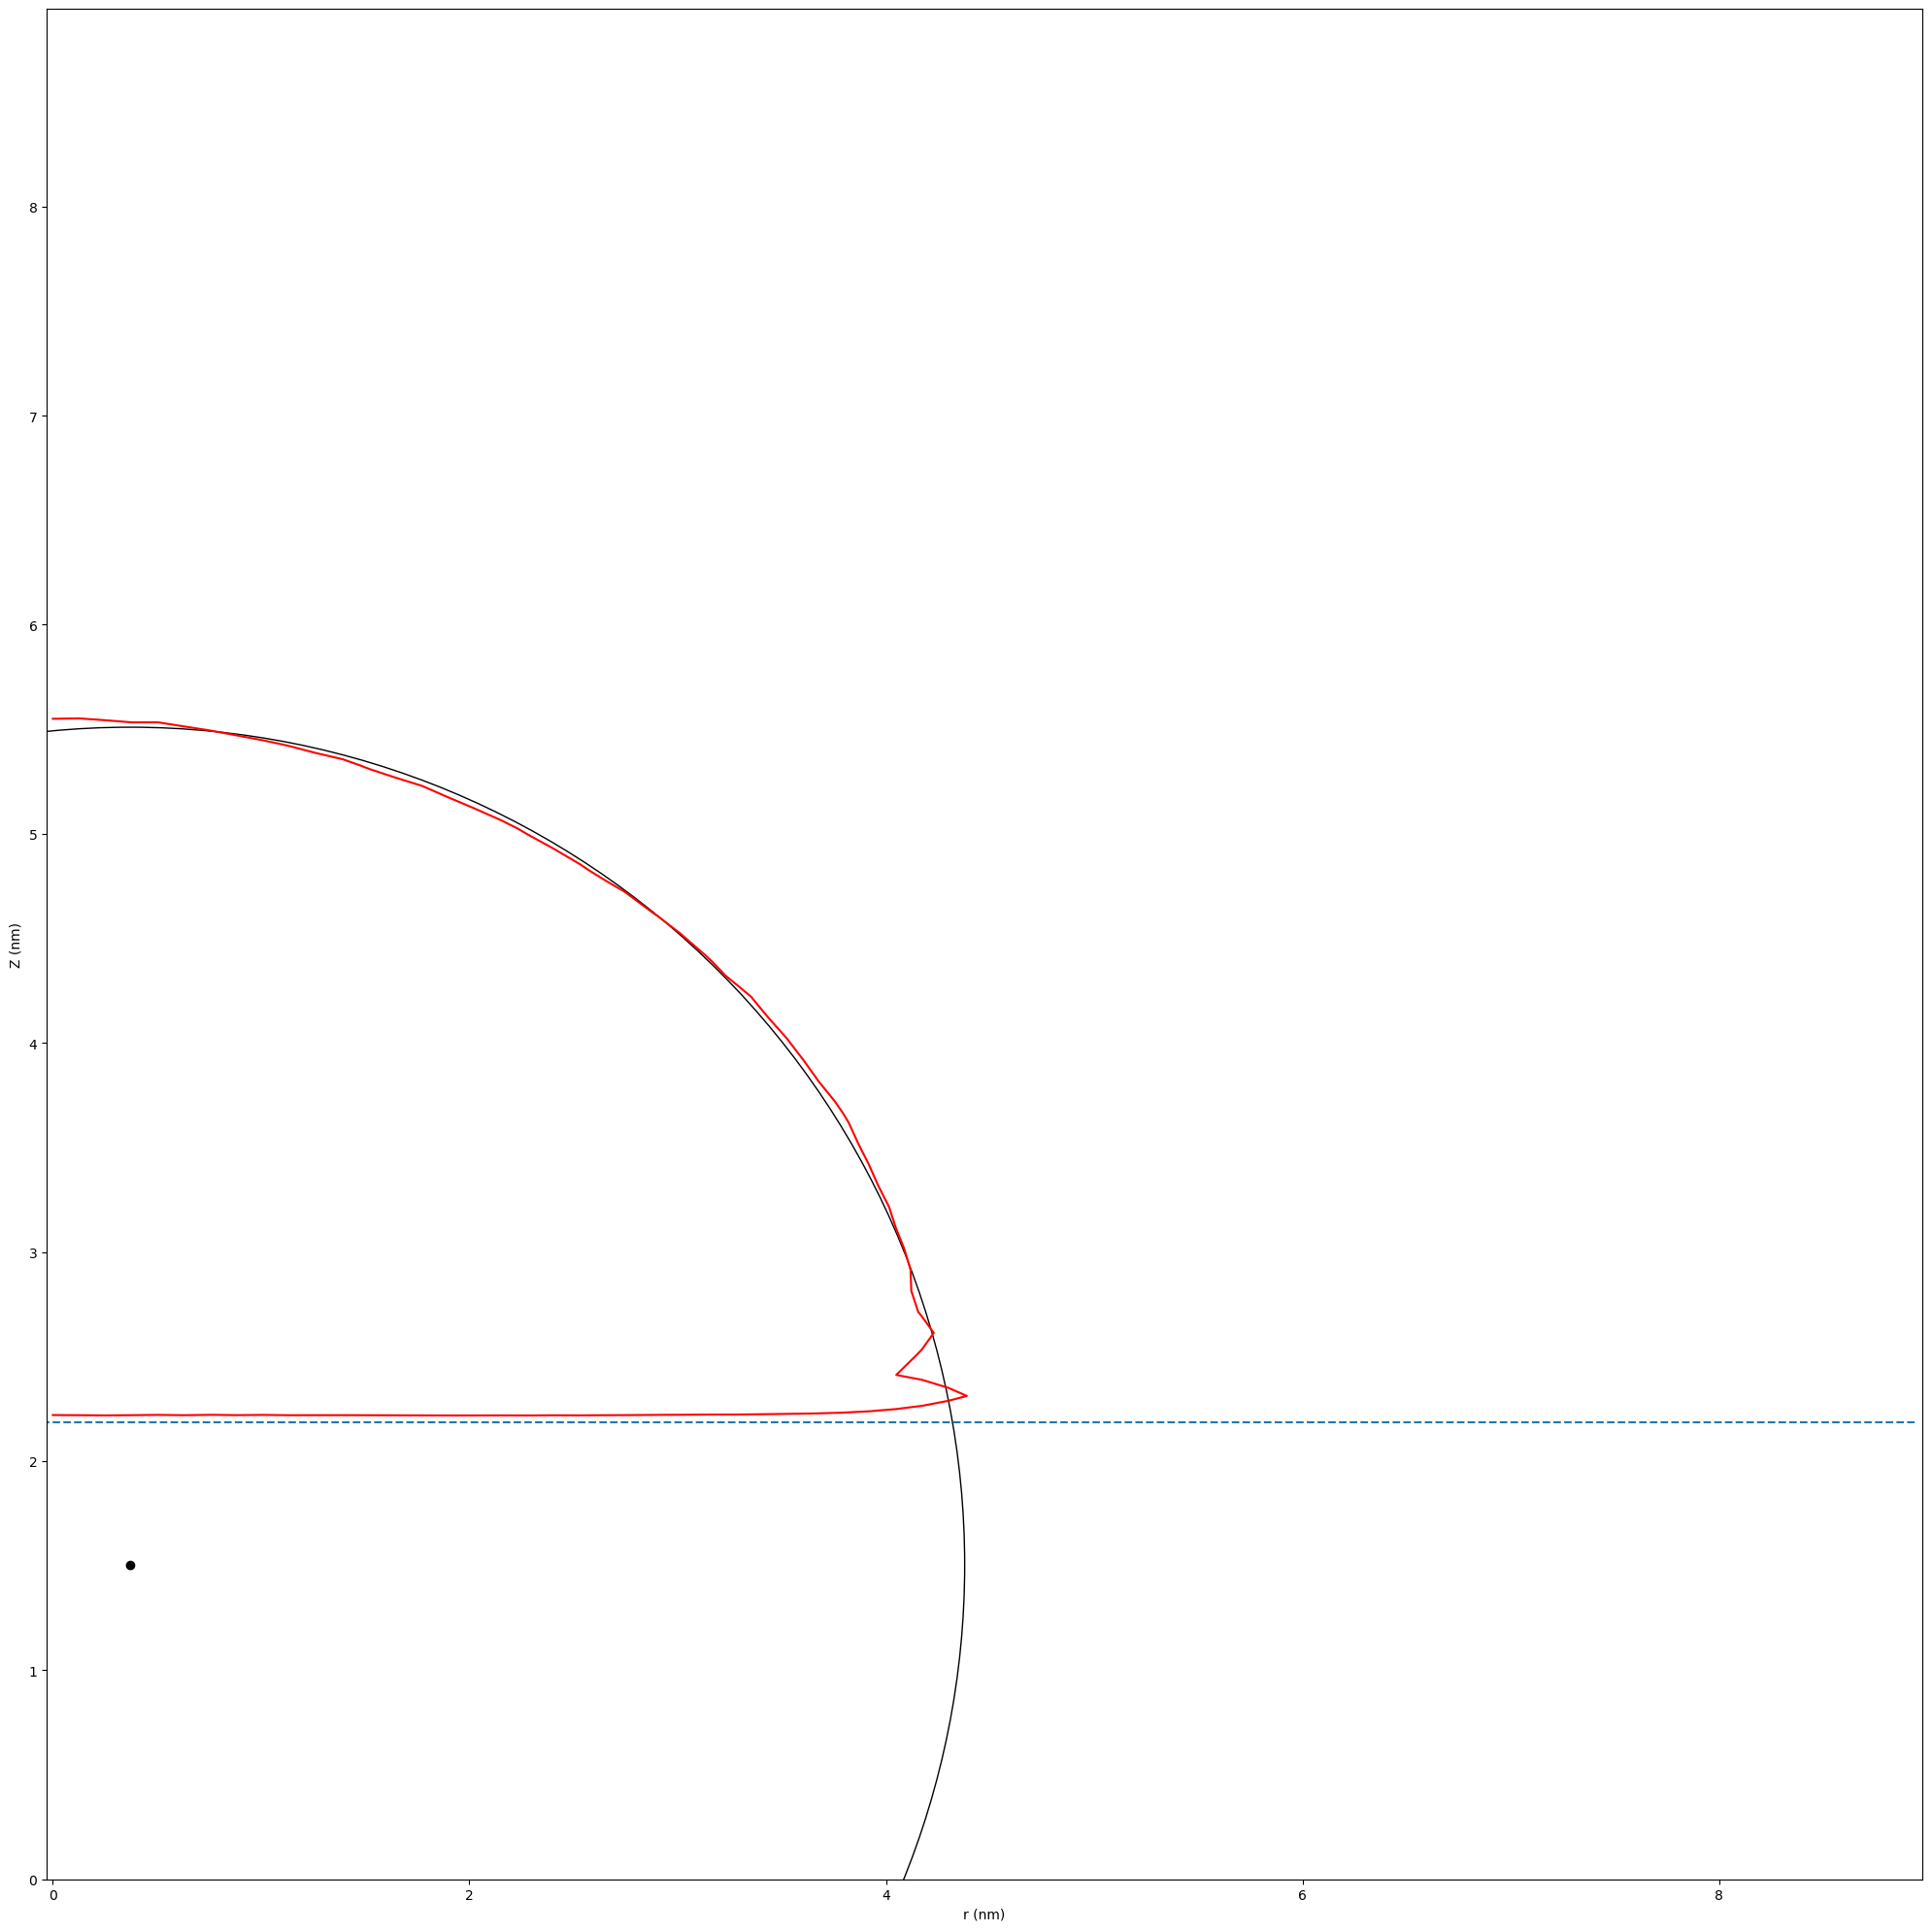

Contact Angle = 80.21649335935173
uncertainty = 0.127067370570049


In [261]:
def circle_func(x, a, b, c):
    return b + np.sqrt(c ** 2 - (x - a) ** 2)

data = masscontour.allsegs[0][alpha]
X, Z = [], []
for i in range(len(data)):
    if data[i][1] > 2.5 and data[i][1] < 5.75:
        Z.append(data[i][1])
        X.append(data[i][0])





## building arrays of the matrix

t1 = []
t2 = []
t3 = []
t4 = []
t5 = []
t6 = []

for i in range(len(X)):
    
    t1.append(X[i]**2)
    t2.append(X[i]*Z[i])
    t3.append(Z[i]**2)
    t4.append(X[i]*(X[i]**2 + Z[i]**2))
    t5.append(Z[i]*(X[i]**2 + Z[i]**2))
    t6.append((X[i]**2 + Z[i]**2))
    




Matrix1 = np.array([[np.sum(t1),np.sum(t2),np.sum(X)], [np.sum(t2),np.sum(t3),np.sum(Z)], [np.sum(X),np.sum(Z),len(X)]])
# m1 = Matrix1.reshape(3,3)

Matrix2 = np.array([np.sum(t4),np.sum(t5),np.sum(t6)])
# m2 = Matrix2.reshape(3,1)

A, B, C = np.linalg.solve(Matrix1, Matrix2) # set_of_variables

if np.allclose(np.dot(Matrix1, [A,B,C]), Matrix2) != True:
    for i in range(1000):
        print("SOMETHING IS WRONG, STOP IT")


a = A/2
b = B/2
R = np.sqrt(4*C + A**2 + B**2)/2

#Checking the fitting

plt.rcParams["figure.figsize"] = [20.00, 20]
plt.rcParams["figure.autolayout"] = True
fig = plt.figure()
ax = fig.add_subplot()
circle1 = patches.Circle((a, b), radius=R,fill=False)
ax.add_patch(circle1)
ax.axis('equal')

X, Z = [], []
for i in range(len(data)):
    if data[i][1] > 0:
        Z.append(data[i][1])
        X.append(data[i][0])
surface_X = np.linspace(-cell[0]/2, cell[0]/2,100)
surface_Y = []
for i in range(len(surface_X)):
    surface_Y.append(Z0)

plt.plot(X,Z,'r')
plt.plot(a,b,'ko')
plt.plot(surface_X,surface_Y,'--')
plt.xlabel('r (nm)')
plt.ylabel('Z (nm)')
plt.xlim([0, cell[0]/2])
plt.ylim([0, cell[1]/2])
plt.show()




# (a,b) = center, a cooresponds to X and b does to Y
# c = R

c = R
arcsin = np.arcsin((b-Z0)/c)
WCA = 90 + m.degrees(arcsin)
print("Contact Angle = " + str(WCA))

cov_matrix = np.linalg.inv(Matrix1)
std_a = np.sqrt(cov_matrix[0, 0])
std_b = np.sqrt(cov_matrix[1, 1])
std_c = np.sqrt(cov_matrix[2, 2])


F = ((b-Z0)/c)
d1 = ( 1 / np.sqrt(1-F**2)) * (1 /c )
d2 = ( 1 / np.sqrt(1-F**2)) * (-F /c )
com1 = (d1 * std_b)**2
com2 = (d2 * std_c)**2

uncertainty = np.sqrt(com1 + com2)
print("uncertainty = " + str(uncertainty))